<a href="https://colab.research.google.com/github/eoinleen/Biophysics-general/blob/main/dinathus-ratio_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 20260114-fitting-Dianthus.xlsx to 20260114-fitting-Dianthus (15).xlsx

OVERLAY PLOTS BY MODEL TYPE


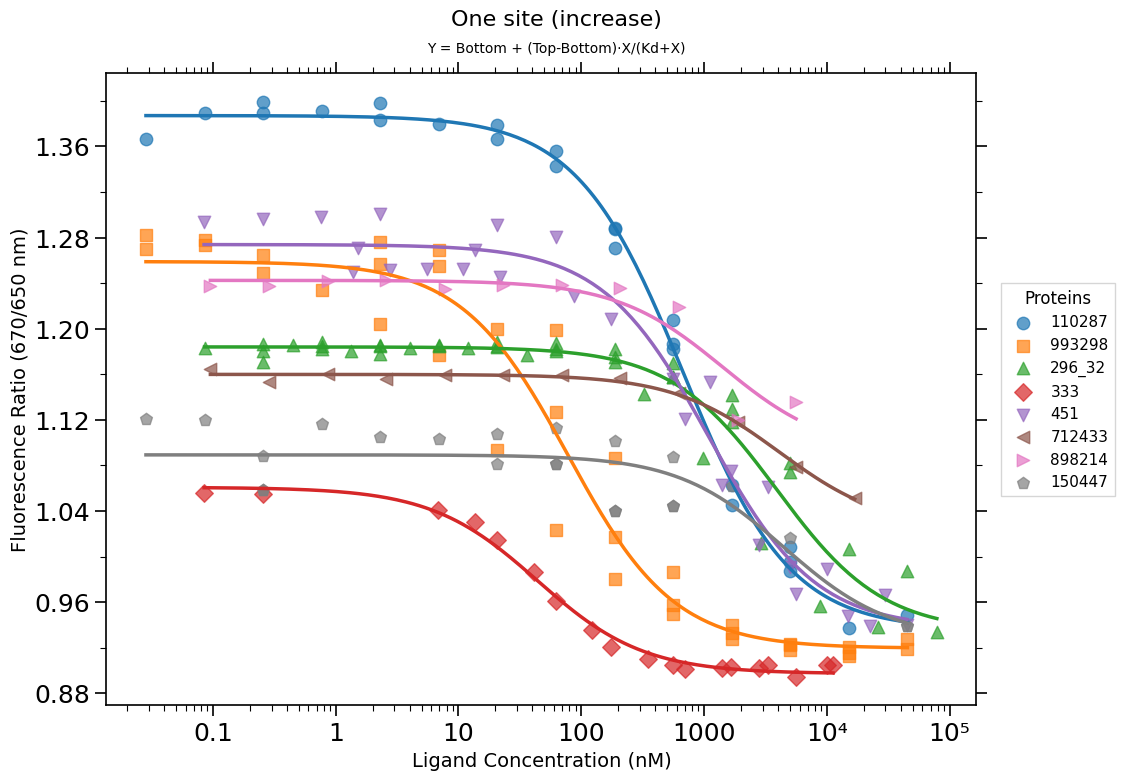

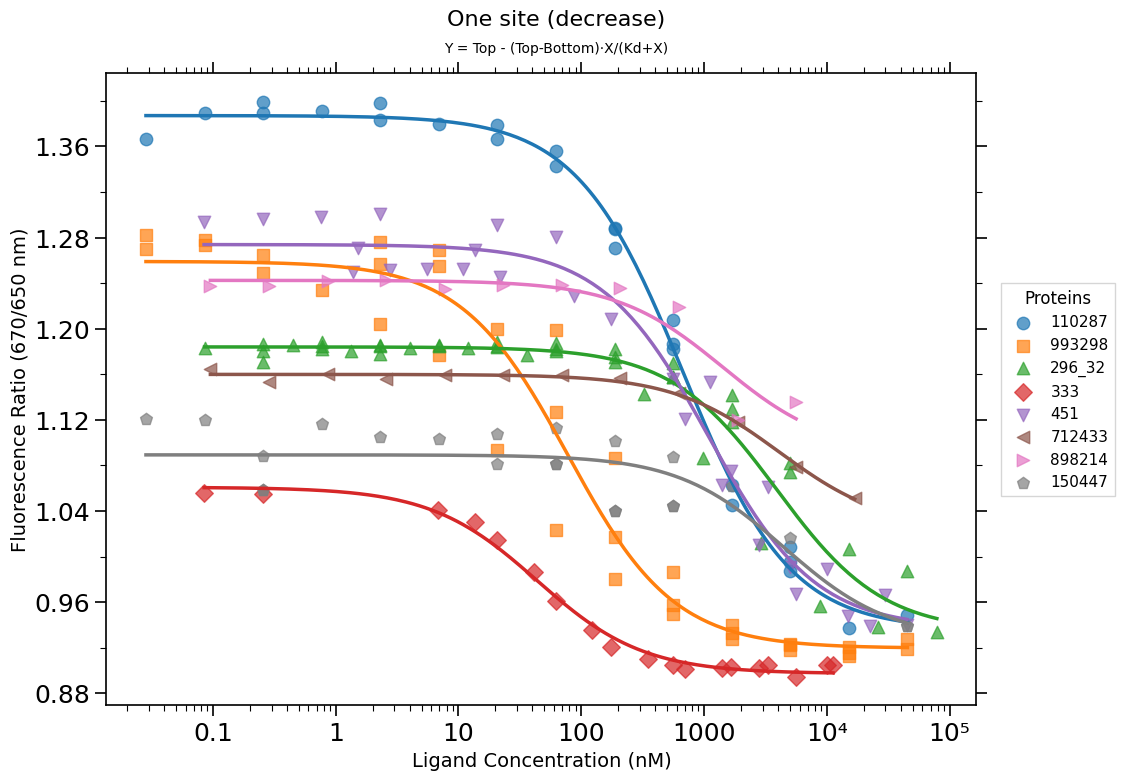

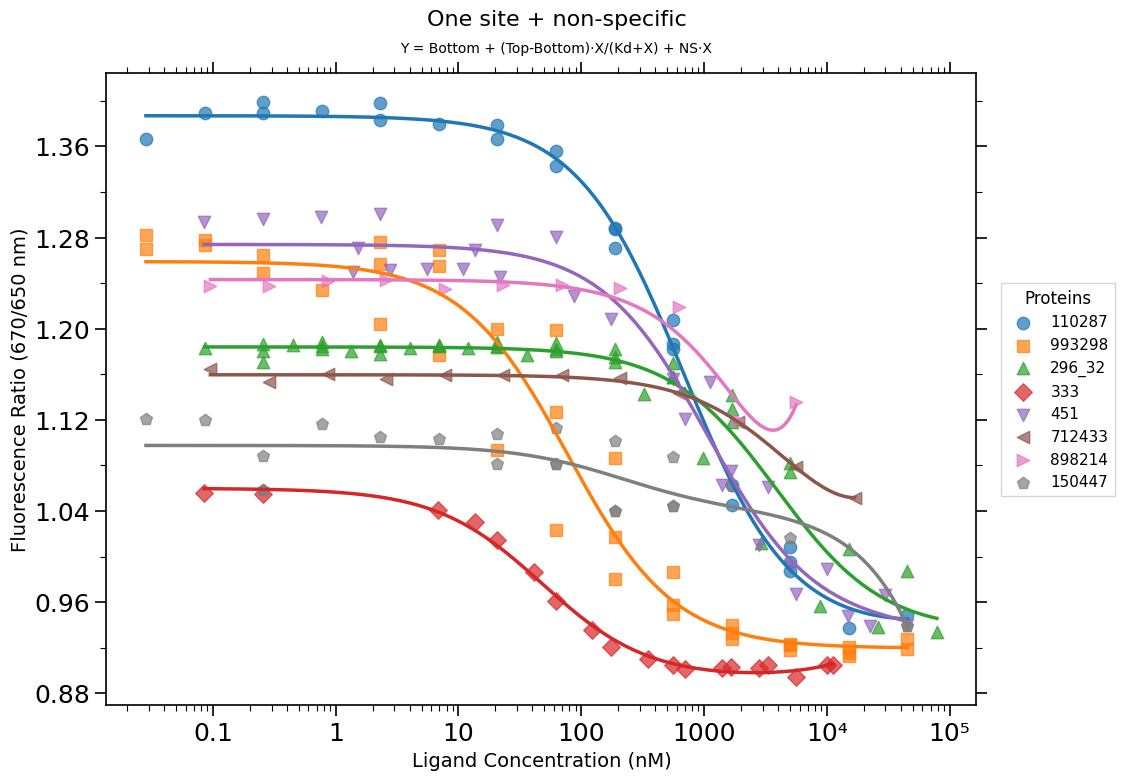

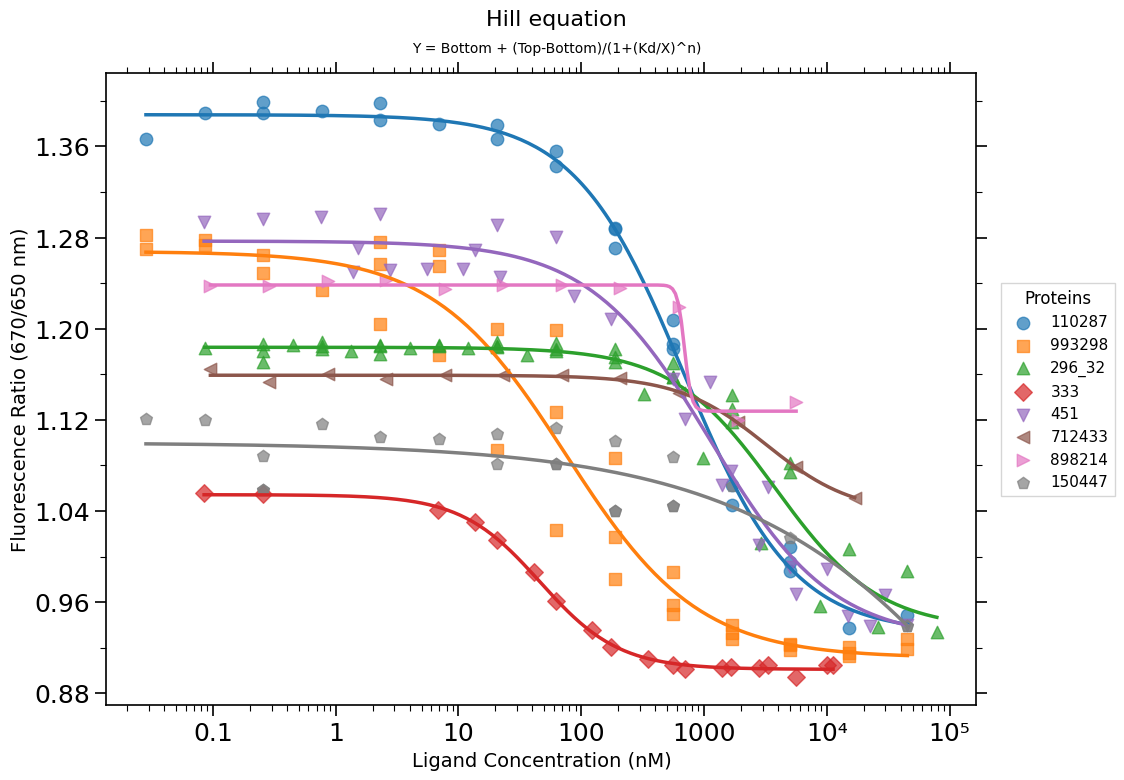

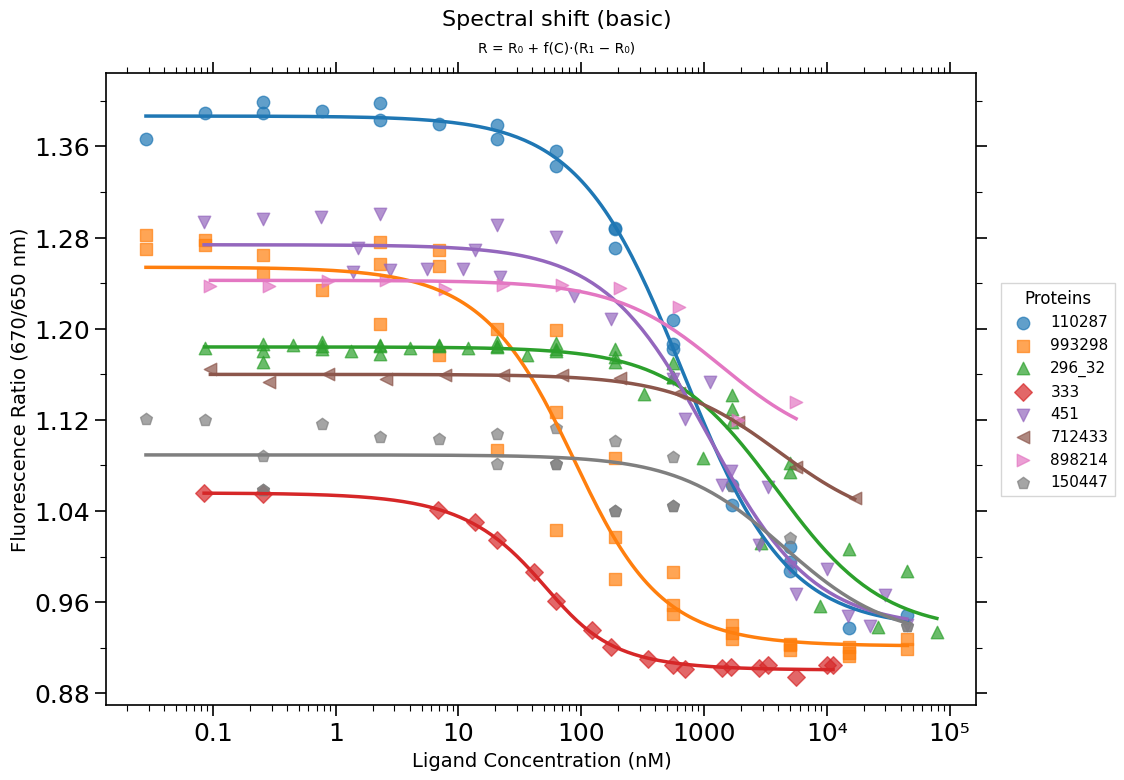


COMPREHENSIVE BINDING ANALYSIS — ALL MODELS, CI-AWARE


/tmp/ipython-input-3911795726.py:141: RuntimeWarning: invalid value encountered in power
  return bottom + (top - bottom) / (1 + (kd / x) ** hill)
/tmp/ipython-input-3911795726.py:237: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(
/tmp/ipython-input-3911795726.py:141: RuntimeWarning: overflow encountered in power
  return bottom + (top - bottom) / (1 + (kd / x) ** hill)


Protein    Model                      Kd(nM)    R²     90% CI             95% CI             CV%    Sat%   Class      CI_flag      Notes
----------------------------------------------------------------------------------------------------------------------------------------
110287     Spectral shift (basic)     647.74    0.995  [558.7–733.3]      [546.3–748.6]      8.3%   98.6   Excellent  OK            spectral-model (max≈70.1×Kd)
110287     One site (decrease)        677.58    0.995  [599.7–760.2]      [579.7–779.3]      7.8%   98.5   Excellent  OK             (max≈67.0×Kd)
110287     One site (increase)        677.58    0.995  [595.2–763.3]      [579.9–794.2]      7.5%   98.5   Excellent  OK             (max≈67.0×Kd)
110287     One site + non-specific    686.50    0.995  [565.2–841.5]      [550.1–906.3]      14.1%  98.5   Excellent  OK             (max≈66.1×Kd)
110287     Hill equation              687.03    0.995  [599.0–834.3]      [581.2–890.5]      10.9%  98.4   Excellent  OK    

In [18]:
"""
Dianthus Binding Assay Analysis Script v9.2
==========================================
Analyzes binding assay data with bidirectional signals and spectral shift models.

DATA REQUIREMENTS & FORMATTING:
-------------------------------
FILE TYPE: .xlsx (Excel)

DATA LAYOUT:
- Column A: Ligand Concentration (in nM)
- Column B: Fluorescence Ratio (e.g., 670/650nm)
- Column C: Ligand Concentration (in nM) for Sample 2
- Column D: Fluorescence Ratio for Sample 2
- (Repeat for additional samples)

HEADER ROWS:
- Row 1: Protein/Sample Names (Place in the concentration column)
- Row 2: Axis Labels (Concentration, Ratio)

NEW IN v11
-----------
- Fixed protein name handling for quoted seed numbers
- Added comprehensive statistics table
- Dynamic "Materials and Methods" generator for publications
- All v9.1 features preserved
"""

# ============================================================================
# USER OPTIONS & REPORTING CONFIGURATION
# ============================================================================

TARGET_PROTEIN_CONCENTRATION_NM = 50.0
TARGET_PROTEIN_CONCENTRATION_M = TARGET_PROTEIN_CONCENTRATION_NM * 1e-9

# REPORT SELECTION: Comment out (#) models NOT used in your final paper
MODELS_TO_REPORT = [
    "One site (increase)",
    "One site (decrease)",
    "One site + non-specific",
    "Hill equation",
    "Spectral shift (basic)",
]

EXCEL_HAS_HEADER = True
PLOT_ALL_DATA_ON_SINGLE_GRAPH = True

# ============================================================================
# STYLE OPTIONS
# ============================================================================

PLOT_STYLE = {
    "font_family": "DejaVu Sans",
    "line_width": 2.5,
    "marker_size": 80,
    "background": "none",
    "grid": False,
    "tick_direction": "out",
    "tick_length_major": 6,
    "tick_length_minor": 3,
}

FONT_SIZES = {
    "title_size": 0,
    "axis_label_size": 18,
    "tick_label_size": 18,
    "annotation_size": 10,
    "legend_size": 10,
}

COLOR_SCHEMES = {
    "presentation": {
        "colors": ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                   '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
        "markers": ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    }
}

ACTIVE_COLOR_SCHEME = "presentation"

def apply_plot_style():
    import matplotlib.pyplot as plt
    plt.rcParams.update({
        "font.family": PLOT_STYLE["font_family"],
        "font.size": FONT_SIZES["tick_label_size"],
        "axes.labelsize": FONT_SIZES["axis_label_size"],
        "xtick.labelsize": FONT_SIZES["tick_label_size"],
        "ytick.labelsize": FONT_SIZES["tick_label_size"],
        "legend.fontsize": FONT_SIZES["legend_size"],
        "axes.linewidth": 1.2,
        "axes.grid": PLOT_STYLE["grid"],
        "figure.facecolor": PLOT_STYLE["background"],
        "axes.facecolor": PLOT_STYLE["background"],
    })

apply_plot_style()

# ============================================================================
# IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import traceback
import sys

try:
    from google.colab import files
    from IPython.display import display
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# ============================================================================
# COLOR MANAGEMENT
# ============================================================================

def get_pair_style(pair_idx):
    scheme = COLOR_SCHEMES[ACTIVE_COLOR_SCHEME]
    return (
        scheme["colors"][pair_idx % len(scheme["colors"])],
        scheme["markers"][pair_idx % len(scheme["markers"])]
    )

# ============================================================================
# MODELS
# ============================================================================

def one_site_binding_increase(x, bottom, top, kd):
    return bottom + (top - bottom) * x / (kd + x)

def one_site_binding_decrease(x, top, bottom, kd):
    return top - (top - bottom) * x / (kd + x)

def one_site_binding_ns(x, bottom, top, kd, ns):
    return bottom + (top - bottom) * x / (kd + x) + ns * x

def hill_equation_bidirectional(x, bottom, top, kd, hill):
    return bottom + (top - bottom) / (1 + (kd / x) ** hill)

def fraction_bound_spectral_shift(c_ligand, kd, c_target):
    term = c_ligand + c_target + kd
    sqrt_term = np.sqrt(np.maximum(term**2 - 4*c_ligand*c_target, 0))
    return np.clip((term - sqrt_term) / (2*c_target), 0, 1)

def spectral_shift_basic(x, r_unbound, r_bound, kd):
    f = fraction_bound_spectral_shift(x, kd, TARGET_PROTEIN_CONCENTRATION_M)
    return r_unbound + f * (r_bound - r_unbound)

def get_equation_string(name):
    return {
        'One site (increase)': 'Y = Bottom + (Top-Bottom)·X/(Kd+X)',
        'One site (decrease)': 'Y = Top - (Top-Bottom)·X/(Kd+X)',
        'One site + non-specific': 'Y = Bottom + (Top-Bottom)·X/(Kd+X) + NS·X',
        'Hill equation': 'Y = Bottom + (Top-Bottom)/(1+(Kd/X)^n)',
        'Spectral shift (basic)': 'R = R₀ + f(C)·(R₁ − R₀)'
    }.get(name, '')


def assess_saturation(model, max_conc):
    """
    Model-aware saturation assessment.
    Returns percent, qualitative class, and diagnostics.
    """

    name = model["name"]
    params = model["params"]
    kd = params[model["kd_index"]]

    # Default outputs
    percent = np.nan
    diagnostic = ""
    extra = ""

    # ---- Model-specific fractional saturation ----
    if name == "Hill equation":
        bottom, top, kd, n = params
        frac = 1 / (1 + (kd / max_conc) ** n)
        percent = 100 * frac
        extra = f"n={n:.2f}"

    elif name in ["One site (increase)", "One site (decrease)", "One site + non-specific"]:
        frac = max_conc / (kd + max_conc)
        percent = 100 * frac

    elif name == "Spectral shift (basic)":
        frac = fraction_bound_spectral_shift(
            max_conc, kd, TARGET_PROTEIN_CONCENTRATION_M
        )
        percent = 100 * frac
        diagnostic = "spectral-model"

    else:
        percent = np.nan

    # ---- Fold-over-Kd diagnostic ----
    fold = max_conc / kd if kd > 0 else np.nan

    # ---- Classification with slope logic ----
    if percent >= 90 and fold >= 10:
        sat_class = "Excellent"
    elif percent >= 75 and fold >= 5:
        sat_class = "Good"
    elif percent >= 60 and fold >= 3:
        sat_class = "Moderate"
    elif percent >= 40:
        sat_class = "Poor"
    else:
        sat_class = "Very Poor"

    diagnostic += f" (max≈{fold:.1f}×Kd)"

    return {
        "percent": percent,
        "class": sat_class,
        "diagnostic": diagnostic,
        "extra": extra
    }

def bootstrap_kd_ci(model, conc, ratios, n_boot=300):
    """
    Bootstrap Kd confidence intervals.
    Returns dict with 90%, 95%, CV or None if unstable.
    """

    func = model["function"]
    params0 = model["params"]
    kd_idx = model["kd_index"]

    kd_vals = []

    for _ in range(n_boot):
        idx = np.random.choice(len(conc), len(conc), replace=True)
        try:
            popt, _ = curve_fit(
                func,
                conc[idx],
                ratios[idx],
                p0=params0,
                maxfev=3000
            )
            kd_vals.append(popt[kd_idx] * 1e9)
        except:
            pass

    # Require reasonable convergence
    if len(kd_vals) < 0.4 * n_boot:
        return None

    kd_vals = np.asarray(kd_vals)

    return {
        "90": np.percentile(kd_vals, [5, 95]),
        "95": np.percentile(kd_vals, [2.5, 97.5]),
        "cv": 100 * np.std(kd_vals) / np.mean(kd_vals)
    }

# ============================================================================
# REPORT GENERATORS
# ============================================================================

def generate_dynamic_methods(selected_models, protein_conc_nm):
    """
    Generates a publication-ready Materials and Methods section
    dynamically based on the user's selected models.
    """
    if not selected_models:
        return "No models selected for reporting."

    count = len(selected_models)
    is_plural = count > 1
    model_list_str = ", ".join(selected_models[:-1]) + (f" and {selected_models[-1]}" if is_plural else selected_models[0])

    equation_details = ""
    for m in selected_models:
        equation_details += f"  - {m}: {get_equation_string(m)}\n"

    methods_text = f"""
{"="*80}
DRAFT: MATERIALS AND METHODS (DATA ANALYSIS)
{"="*80}

DATA PROCESSING AND MODELING:
Binding affinity (Kd) was determined by analyzing the change in fluorescence
ratios as a function of ligand concentration. Data analysis was performed
using a custom Python-based analysis suite (v9.2) utilizing the SciPy
optimization library.

1. MODEL SELECTION & EQUATION(S)
The experimental data {"were" if is_plural else "was"} fit to the {model_list_str} {"models" if is_plural else "model"}.
The following {"equations were" if is_plural else "equation was"} utilized:
{equation_details}

2. COMPUTATIONAL FITTING PROCEDURE
Non-linear least squares regression was performed using the 'curve_fit'
algorithm from the SciPy 'optimize' module (v1.11+). The algorithm utilized
the Trust Region Reflective (TRF) method with a maximum of 5,000 iterations.
Initial parameter guesses were programmatically generated based on the median
concentration and signal range of the raw data to ensure global convergence.

3. KD DETERMINATION & CONFIDENCE INTERVALS
Kd was derived as a fitted parameter representing the dissociation constant.
For the Spectral Shift model, the script accounts for the depletion of
free ligand by incorporating the fixed target protein concentration
([{protein_conc_nm} nM]) into a quadratic binding equation.

Statistical uncertainty for the Kd values was estimated using a non-parametric
bootstrap analysis (n=300). Experimental data points were resampled with
replacement, and each synthetic dataset was re-fit to the chosen model(s).
The 95% confidence intervals (CIs) were defined by the 2.5th and 97.5th
percentiles of the resulting Kd distribution.

4. GOODNESS OF FIT AND QUALITY CONTROL
The coefficient of determination (R²) was calculated as:
    R² = 1 - (SS_res / SS_tot)
where SS_res is the sum of squares of residuals and SS_tot is the total
sum of squares. Fits were categorized by saturation percentage; results where
the maximum ligand concentration failed to reach 3x the calculated Kd, or
where theoretical saturation was below 60%, were flagged as "Extrapolated"
to denote reduced numerical confidence.

{"="*80}
"""
    print(methods_text)

# ============================================================================
# FITTING
# ============================================================================

def analyze_binding_data(conc_m, ratios):
    models = []

    conc = np.asarray(conc_m)
    ratios = np.asarray(ratios)
    mask = (conc > 0) & np.isfinite(conc) & np.isfinite(ratios)
    conc, ratios = conc[mask], ratios[mask]

    if len(conc) < 4:
        return None

    bottom, top = np.min(ratios), np.max(ratios)
    kd_guess = np.median(conc)

    def try_fit(name, func, p0, bounds, kd_index):
        try:
            popt, pcov = curve_fit(func, conc, ratios, p0=p0, bounds=bounds, maxfev=5000)
            fitted = func(conc, *popt)
            ss_res = np.sum((ratios - fitted)**2)
            ss_tot = np.sum((ratios - np.mean(ratios))**2)
            r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
            models.append({
                "name": name,
                "function": func,
                "params": popt,
                "kd_index": kd_index,
                "r2": r2,
                "equation": get_equation_string(name)
            })
        except Exception:
            pass

    try_fit("One site (increase)", one_site_binding_increase,
            [bottom, top, kd_guess], ([0,0,1e-12],[np.inf]*3), 2)

    try_fit("One site (decrease)", one_site_binding_decrease,
            [top, bottom, kd_guess], ([0,0,1e-12],[np.inf]*3), 2)

    try_fit("One site + non-specific", one_site_binding_ns,
            [bottom, top, kd_guess, 0], ([0,0,1e-12,-np.inf],[np.inf]*4), 2)

    try_fit("Hill equation", hill_equation_bidirectional,
            [bottom, top, kd_guess, 1], ([0,0,1e-12,0.1],[np.inf]*4), 2)

    try_fit("Spectral shift (basic)", spectral_shift_basic,
            [ratios[0], ratios[-1], kd_guess], ([0,0,1e-12],[np.inf]*3), 2)

    if not models:
        return None

    best = max(models, key=lambda m: m["r2"])

    x_smooth = np.logspace(np.log10(conc.min()), np.log10(conc.max()), 200)
    y_smooth = best["function"](x_smooth, *best["params"])

    return {
        "original_conc": conc,
        "original_ratios": ratios,
        "smooth_conc": x_smooth,
        "smooth_ratios": y_smooth,
        "parameters": best["params"],
        "kd_index": best["kd_index"],
        "method": best["name"],
        "equation": best["equation"],
        "all_models": models
    }

# ============================================================================
# PLOTTING
# ============================================================================

def plot_overlays_by_model(all_data, fit_results, protein_names=None):
    print("\nOVERLAY PLOTS BY MODEL TYPE")

    from matplotlib.ticker import FuncFormatter, MultipleLocator, MaxNLocator

    def smart_log_formatter(x, pos):
        if x <= 0:
            return ""

        if x < 10000:
            if x >= 1:
                return f"{x:.0f}"
            else:
                return f"{x:.1f}"

        exponent = int(np.log10(x))
        mantissa = x / (10 ** exponent)

        superscripts = str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻")

        if abs(mantissa - 1.0) < 1e-6:
            return f"10{str(exponent).translate(superscripts)}"
        else:
            return f"{mantissa:.0f}×10{str(exponent).translate(superscripts)}"

    grouped = {}
    for pair_idx, result in fit_results.items():
        for model in result["all_models"]:
            grouped.setdefault(model["name"], []).append((pair_idx, model))

    for model_name, entries in grouped.items():
        fig, ax = plt.subplots(figsize=(12, 8))

        for pair_idx, model in entries:
            color, marker = get_pair_style(pair_idx)
            data = all_data[pair_idx]

            conc_nm = data["conc_m"] * 1e9

            if protein_names and pair_idx < len(protein_names):
                label = protein_names[pair_idx]
            else:
                label = f"Sample {pair_idx + 1}"

            ax.scatter(conc_nm, data["ratios"], s=80, color=color,
                      alpha=0.7, marker=marker, label=label)

            xs = np.logspace(np.log10(data["conc_m"].min()),
                             np.log10(data["conc_m"].max()), 200)
            ys = model["function"](xs, *model["params"])
            ax.plot(xs*1e9, ys, color=color, linewidth=2.5)

        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(FuncFormatter(smart_log_formatter))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
        ax.yaxis.set_minor_locator(MaxNLocator(nbins=16))

        ax.tick_params(axis='both', which='major',
                      length=8, width=1.2, direction='out')
        ax.tick_params(axis='both', which='minor',
                      length=4, width=0.8, direction='out')
        ax.tick_params(top=True, right=True, which='both')

        ax.set_xlabel("Ligand Concentration (nM)", fontsize=14)
        ax.set_ylabel("Fluorescence Ratio (670/650 nm)", fontsize=14)

        equation_text = get_equation_string(model_name)
        fig.suptitle(f"{model_name}", fontsize=16, y=0.98)
        fig.text(0.5, 0.94, equation_text,
                ha='center', va='top', fontsize=10,
                transform=fig.transFigure)

        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                 frameon=True, fancybox=False, shadow=False,
                 fontsize=11, title="Proteins", title_fontsize=12)

        plt.subplots_adjust(top=0.90, right=0.85)
        plt.show()

# ============================================================================
# STATISTICS
# ============================================================================

def print_statistics_table(fit_results, protein_names):
    print("\n" + "=" * 190)
    print("COMPREHENSIVE BINDING ANALYSIS — ALL MODELS, CI-AWARE")
    print("=" * 190)

    rows = []

    for pair_idx, result in fit_results.items():
        protein = (
            protein_names[pair_idx]
            if protein_names and pair_idx < len(protein_names)
            else f"Sample {pair_idx+1}"
        )

        conc = result["original_conc"]
        ratios = result["original_ratios"]
        max_conc = np.max(conc)

        for model in result["all_models"]:
            name = model["name"]
            r2 = model["r2"]
            params = model["params"]

            kd = params[model["kd_index"]]
            kd_nm = kd * 1e9

            # ---- Saturation assessment ----
            sat = assess_saturation(model, max_conc)

            # ---- CI logic with flags ----
            ci_90 = ci_95 = cv = "—"
            ci_flag = "OK"

            fold = max_conc / kd if kd > 0 else np.nan

            if sat["percent"] < 60:
                ci_flag = "LOW_SAT"
            elif r2 < 0.95:
                ci_flag = "POOR_FIT"
            elif fold < 3:
                ci_flag = "EXTRAPOLATED"
            else:
                ci = bootstrap_kd_ci(model, conc, ratios)
                if ci is None:
                    ci_flag = "BOOT_FAIL"
                else:
                    ci_90 = f"[{ci['90'][0]:.1f}–{ci['90'][1]:.1f}]"
                    ci_95 = f"[{ci['95'][0]:.1f}–{ci['95'][1]:.1f}]"
                    cv = f"{ci['cv']:.1f}%"

            rows.append({
                "protein": protein,
                "model": name,
                "kd": kd_nm,
                "r2": r2,
                "sat": sat["percent"],
                "class": sat["class"],
                "ci_90": ci_90,
                "ci_95": ci_95,
                "cv": cv,
                "ci_flag": ci_flag,
                "extra": sat["extra"],
                "diag": sat["diagnostic"]
            })

    # Sort by protein then saturation
    rows.sort(key=lambda r: (r["protein"], -r["sat"], -r["r2"]))

    header = (
         f"{'Protein':<10} {'Model':<26} {'Kd(nM)':<9} "
         f"{'R²':<6} "
         f"{'90% CI':<18} {'95% CI':<18} {'CV%':<6} "
         f"{'Sat%':<6} {'Class':<10} {'CI_flag':<12} {'Notes'}"
    )
    print(header)
    print("-" * len(header))

    last = None
    for r in rows:
        if last and r["protein"] != last:
            print("-" * len(header))

        print(
            f"{r['protein']:<10} "
            f"{r['model']:<26} "
            f"{r['kd']:<9.2f} "
            f"{r['r2']:<6.3f} "
            f"{r['ci_90']:<18} "
            f"{r['ci_95']:<18} "
            f"{r['cv']:<6} "
            f"{r['sat']:<6.1f} "
            f"{r['class']:<10} "
            f"{r['ci_flag']:<12} "
            f"{r['extra']} {r['diag']}"
        )
        last = r["protein"]

    print("=" * len(header))

    # ---- CI legend ----
    print("\nCI FLAG LEGEND:")
    print("  OK           CI reliable")
    print("  LOW_SAT      <60% saturation — Kd poorly constrained")
    print("  POOR_FIT     R² < 0.95")
    print("  EXTRAPOLATED Max conc < 3×Kd")
    print("  BOOT_FAIL    Bootstrap unstable / non-convergent")



# ============================================================================
# FILE ANALYSIS
# ============================================================================

def analyze_uploaded_file_multi(filename):
    df_header = pd.read_excel(filename, header=None, nrows=2)

    protein_names = []
    for i in range(0, df_header.shape[1], 2):
        name = df_header.iloc[0, i]
        if pd.notna(name):
            name_str = str(name).strip('"').strip("'")
            protein_names.append(name_str)
        else:
            if i+1 < df_header.shape[1]:
                name = df_header.iloc[0, i+1]
                if pd.notna(name):
                    name_str = str(name).strip('"').strip("'")
                    protein_names.append(name_str)

    df_data = pd.read_excel(filename, header=1)
    n_pairs = df_data.shape[1] // 2

    all_data, fit_results = {}, {}

    for i in range(n_pairs):
        conc_nm = df_data.iloc[:,2*i].dropna().values
        ratios = df_data.iloc[:,2*i+1].dropna().values
        n = min(len(conc_nm), len(ratios))

        conc_m = conc_nm[:n] * 1e-9
        ratios = ratios[:n]

        all_data[i] = {"conc_m": conc_m, "ratios": ratios}

        res = analyze_binding_data(conc_m, ratios)
        if res:
            fit_results[i] = res

    plot_overlays_by_model(all_data, fit_results, protein_names)
    print_statistics_table(fit_results, protein_names)

# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    if IN_COLAB:
        uploaded = files.upload()
        if uploaded:
            filename = list(uploaded.keys())[0]
            analyze_uploaded_file_multi(filename)
            generate_dynamic_methods(MODELS_TO_REPORT, TARGET_PROTEIN_CONCENTRATION_NM)